In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature  # Import cartopy features for coastlines, etc.
import pandas as pd
import numpy as np
import datetime

In [2]:
ds = xr.open_dataset("2024/2024.grib", engine="cfgrib")
df = pd.read_csv("rota_suezmax.csv", sep=';')

In [3]:
df["LAT"] = df["LAT"].str.replace(",", ".").astype(float)
df["LON"] = df["LON"].str.replace(",", ".").astype(float)
df["Data"] = pd.to_datetime(df["Data"].str.strip())


In [14]:
def calc_dist(lat1, lon1, lat2, lon2):
    R = 6378100
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dlambda = np.radians(lon2 - lon1)
    hav = lambda angle: (1-np.cos(angle))/2
    h = hav(phi2 - phi1) + np.cos(phi1) * np.cos(phi2) * hav(dlambda)

    return R * 2 * np.arctan2(np.sqrt(h), np.sqrt(1 - h))

def calc_ang_deg(lat1, lon1, lat2, lon2):
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    dlon = lon2 - lon1
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    y = np.sin(dlon) * np.cos(lat2)
    ang = np.arctan2(y, x)
    ang_deg = (np.degrees(ang) + 360) % 360  # Garante valor entre 0 e 360
    return ang_deg

def wind_dri(u, v):
    return (np.degrees(np.arctan2(u, v)) + 360) % 360

vs_kns = 12 # Knots
vs_ms = vs_kns / 1.94384
tempo_atual = pd.Timestamp("2024-01-01 00:00:00")

# Entre 0 a 8784
stamp_vento = 0

for i in range(0, 30000, 1):
    lat1, lon1 = df.loc[i, "LAT"], df.loc[i, "LON"]
    lat2, lon2 = df.loc[i+1, "LAT"], df.loc[i+1, "LON"]
    diff = (df.loc[i+1, "Data"] - df.loc[i, "Data"]).total_seconds()
    dist = calc_dist(lat1, lon1, lat2, lon2) # Em metros
    angulo = calc_ang_deg(lat1, lon1, lat2, lon2)
    vx_navio = vs_ms * np.sin(np.radians(angulo))
    vy_navio = vs_ms * np.cos(np.radians(angulo))
    

    dt = dist/vs_ms
    if dt > 100: print(angulo, lat1, lon1, dt)

    # tempo_atual += pd.Timedelta(seconds=dt)
    # u10_point1 = ds.u10.sel(latitude=lat1, longitude=-lon1, method="nearest")
    # v10_point1 = ds.v10.sel(latitude=lat1, longitude=-lon1, method="nearest")
    # u10_point2 = ds.u10.sel(latitude=lat2, longitude=lon2, method="nearest")
    # v10_point2 = ds.v10.sel(latitude=lat2, longitude=lon2, method="nearest")
    # u10 = u10_point1.sel(time=tempo_atual, method='nearest').values
    # v10 = v10_point1.sel(time=tempo_atual, method='nearest').values
    # ang_vento = wind_dri(u10, v10)

    # print(f"LAT1 {lat1} LON1 {lon1}")
    # print(f"LAT2 {lat2} LON2 {lon2}")
    # print("Velocidade horizontal do navio: ", vx_navio)
    # print("Velocidade vertical do navio: ", vy_navio)
     
    # # (0° = Norte, 90° = Leste, 180° = Sul, 270° = Oeste)
    # print("Tempo entre pontos (seg): ", dt)
    # print("Tempo atual: ", tempo_atual)

    # # Componente zonal (leste-oeste)
    # print("Velocidade de vento horizontal: ", u10)

    # # Componente meridional (norte-sul)
    # print("Velocidade de vento vertical: ", v10)

    # print("Angulo do vento: ", ang_vento)
    # print()
    
    

265.4660640850657 -23.7626304626 -45.3660049438 136.17719361582513
265.3654374462379 -23.7700042725 -45.3677864075 176.69226687375064
266.94610958582643 -23.7795810699 -45.3700523376 183.41942112093017
267.4297997790127 -23.7892360687 -45.373550415 155.57156514728638
268.1832187730572 -23.7972602844 -45.3770141602 139.4206020084537
88.2132045995142 -23.8044490814 -45.3823013306 175.7456761723225
87.59139238535818 -23.795879364 -45.3772277832 189.71589107054407
87.59171093340728 -23.7861328125 -45.3728981018 167.98086792930502
87.44261424937332 -23.7775058746 -45.3690567017 114.04527720388887
266.74619742496657 -23.772611618 -45.3668518066 105.94521543119026
267.0850734301287 -23.7782249451 -45.3687477112 121.45011696349384
267.82602557724283 -23.7845897675 -45.3711547852 123.47437390288864
267.9376496385298 -23.7907924652 -45.3743247986 115.39431853493002
268.91243715166615 -23.813035965 -45.3864898682 100.98154824163741
269.0070008014055 -23.8170700073 -45.3907356262 168.5903556067492

KeyError: 24001

In [5]:
import folium

# Crie um mapa centralizado no ponto médio dos dados
lat_center = df["LAT"].mean()
lon_center = df["LON"].mean()
m = folium.Map(location=[lat_center, lon_center], zoom_start=3)

# Adicione marcadores para cada ponto
for idx, row in df.iterrows():
    folium.Marker(
        location=[row["LAT"], row["LON"]],
        popup=f"u10: {row['u10']:.2f} m/s<br>v10: {row['v10']:.2f} m/s"
    ).add_to(m)

# Salve o mapa em um arquivo HTML
m.save("mapa_vento.html")

KeyError: 'u10'

c:\Users\jungeui_choi\AppData\Local\anaconda3\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\jungeui_choi\AppData\Local\anaconda3\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\jungeui_choi\AppData\Local\anaconda3\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\jungeui_choi\AppData\Local\anaconda3\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', 

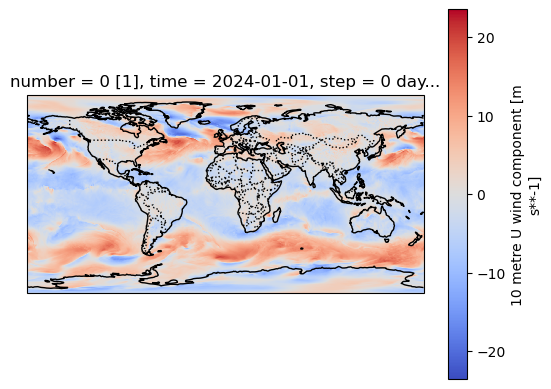

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})  # Use PlateCarree projection for global maps
ds.u10[0].plot(cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree())
# Add coastlines and other features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

plt.show()